In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time
import auxiliar as ax
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer
from skopt import gp_minimize
from sklearn.metrics import root_mean_squared_error

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'

In [2]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])


significantLags: [1, 5, 8, 10, 19, 25]
          Date       Close   (Close-1)   (Close-5)   (Close-8)  (Close-10)  \
25  2020-10-07  141.766663  137.993332  143.003326  135.779999  126.786667   
26  2020-10-08  141.973328  141.766663  149.386673  140.399994  129.263336   

    (Close-19)  (Close-25)  
25  123.779999  158.350006  
26  124.239998  149.123337  


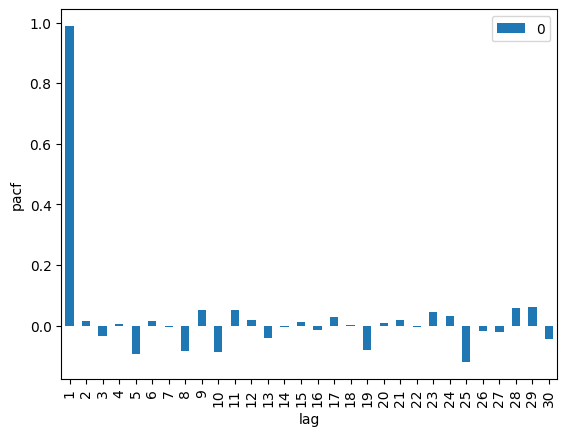

In [3]:
tesla_significantLags = ax.getSignificantLags(y=TESLA['Close'], nLags =30, alpha=0.05)

TM_tesla = ax.appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)

In [4]:
df_tesla = TM_tesla.dropna()
# Separar features e target
X = df_tesla.drop('Close', axis=1)
X = X.drop('Date', axis=1)
X = X
y = df_tesla['Close']



In [5]:
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
from sklearn.preprocessing import StandardScaler

x_scale_tesla = StandardScaler()
y_scale_tesla1 = StandardScaler()
y_scale_tesla2 = StandardScaler()

X_train_scaled_tesla = x_scale_tesla.fit_transform(X_train_tesla)
X_test_scaled_tesla = x_scale_tesla.fit_transform(X_test_tesla)

y_train_scaled_tesla = y_scale_tesla1.fit_transform(y_train_tesla.values.reshape(-1, 1))
y_test_scaled_tesla = y_scale_tesla1.fit_transform(y_test_tesla.values.reshape(-1, 1))

y_train_scaled_tesla = y_scale_tesla2.fit_transform(y_train_tesla.values.reshape(-1, 1))
y_test_scaled_tesla = y_scale_tesla2.fit_transform(y_test_tesla.values.reshape(-1, 1))

'''X_train_scaled_tesla = np.array(X_train_tesla)
X_test_scaled_tesla = np.array(X_test_tesla)

y_train_scaled_tesla = np.array(y_train_tesla)
y_test_scaled_tesla = np.array(y_test_tesla)'''

'X_train_scaled_tesla = np.array(X_train_tesla)\nX_test_scaled_tesla = np.array(X_test_tesla)\n\ny_train_scaled_tesla = np.array(y_train_tesla)\ny_test_scaled_tesla = np.array(y_test_tesla)'

In [7]:
import krlst_implement as KRLS

In [8]:
modelo_sem_SVD = KRLS.Krls_t(lambda_= 0.0001, c=0.00001,M=100, sigma = 1)

In [9]:
start_time = time.time()
for i in range(len(X_train_tesla)):
    modelo_sem_SVD.learn_one(X_train_scaled_tesla[i], y_train_scaled_tesla[i], int(X_train_tesla.index[i]))
end_time = time.time()
execution_time_partial_fit = end_time - start_time

In [10]:
start_time = time.time()
previsoes_krls_t_sem_svd = []
for j in range(len(X_test_tesla)):
    y_pred, desv = modelo_sem_SVD.predict(X_test_scaled_tesla[j])
    modelo_sem_SVD.learn_one(X_test_scaled_tesla[j], y_test_scaled_tesla[j], int(X_test_tesla.index[j]))
    previsoes_krls_t_sem_svd.append(y_pred)
end_time = time.time()
execution_time_previsoes = end_time - start_time

In [11]:
index = pd.DataFrame(X_test_tesla).index

In [12]:
previsoes_krls_t_sem_svd = [arr[0, 0] for arr in previsoes_krls_t_sem_svd]

In [13]:
previsoes_krls_t_sem_svd = y_scale_tesla1.inverse_transform(np.array([previsoes_krls_t_sem_svd]))

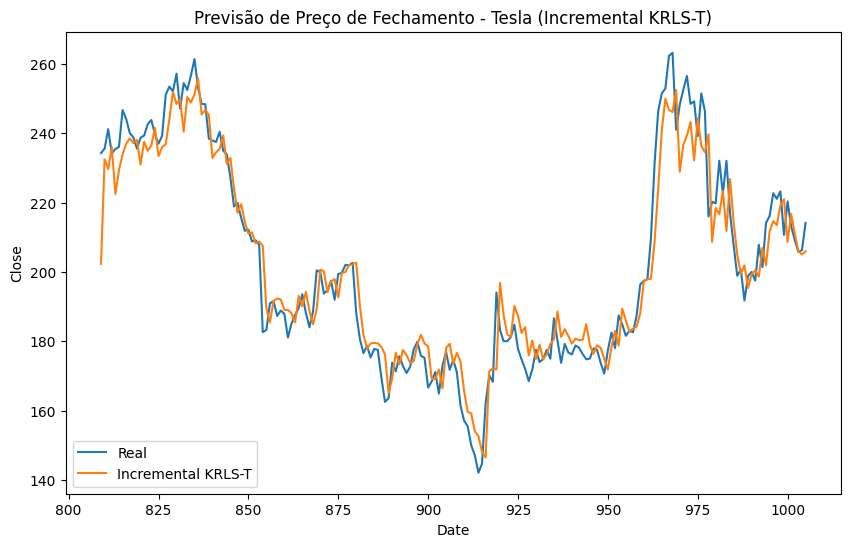

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Real')
plt.plot(X_test_tesla.index, previsoes_krls_t_sem_svd[0], label='Incremental KRLS-T')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS-T)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [15]:
modelo_com_SVD = KRLS.Krls_t(lambda_= 0.0001, c=0.00001,M=30, sigma = 1, using_SVD= True)

In [16]:
start_time = time.time()
for i in range(len(X_train_tesla)):
    modelo_com_SVD.learn_one(X_train_scaled_tesla[i], y_train_scaled_tesla[i], int(X_train_tesla.index[i]))
end_time = time.time()
execution_time_partial_fit_SVD = end_time - start_time

In [17]:
start_time = time.time()
previsoes_krls_t_com_svd = []
for j in range(len(X_test_tesla)):
    y_pred, desv = modelo_com_SVD.predict(X_test_scaled_tesla[j])
    modelo_com_SVD.learn_one(X_test_scaled_tesla[j], y_test_scaled_tesla[j], int(X_test_tesla.index[j]))
    previsoes_krls_t_com_svd.append(y_pred)
end_time = time.time()
execution_time_previsoes_SVD = end_time - start_time

In [18]:
previsoes_krls_t_com_svd = [arr[0, 0] for arr in previsoes_krls_t_com_svd]

In [19]:
previsoes_krls_t_com_svd = y_scale_tesla2.inverse_transform(np.array([previsoes_krls_t_com_svd]))

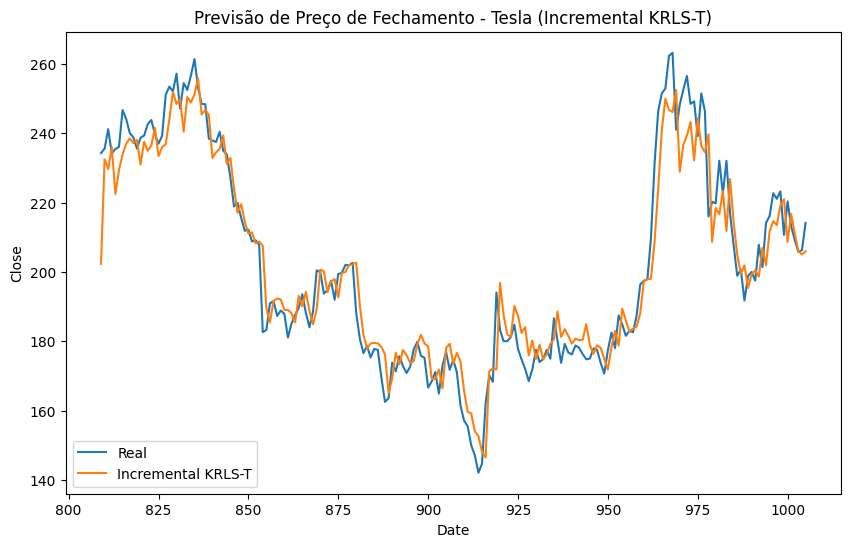

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Real')
plt.plot(X_test_tesla.index, previsoes_krls_t_com_svd[0], label='Incremental KRLS-T')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS-T)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [22]:
print(f'MSE sem SVD: {mean_squared_error(y_test_tesla, previsoes_krls_t_sem_svd[0])}')
print(f'MSE com SVD: {mean_squared_error(y_test_tesla, previsoes_krls_t_com_svd[0])}')
print(f'MAE sem SVD: {mean_absolute_error(y_test_tesla, previsoes_krls_t_sem_svd[0])}')
print(f'MAE com SVD: {mean_absolute_error(y_test_tesla, previsoes_krls_t_com_svd[0])}')
print(f'RMSE sem SVD: {root_mean_squared_error(y_test_tesla, previsoes_krls_t_sem_svd[0])}')
print(f'RMSE com SVD: {root_mean_squared_error(y_test_tesla, previsoes_krls_t_com_svd[0])}')

MSE sem SVD: 69.84829044951937
MSE com SVD: 69.84829042332325
MAE sem SVD: 6.2856515819654595
MAE com SVD: 6.285651580404993
RMSE sem SVD: 8.357528967913863
RMSE com SVD: 8.357528966346647


In [ ]:
print(f'Tempo partial_fit s/ SVD: {execution_time_partial_fit}')
print(f'Tempo previsoes s/ SVD: {execution_time_previsoes}')

print(f'Tempo partial_fit c/ SVD: {execution_time_partial_fit_SVD}')
print(f'Tempo previsoes c/ SVD: {execution_time_previsoes_SVD}')

Tempo partial_fit s/ SVD: 1.3268518447875977
Tempo previsoes s/ SVD: 0.5963027477264404
Tempo partial_fit c/ SVD: 1.0780045986175537
Tempo previsoes c/ SVD: 0.2986621856689453


In [28]:
metrica_sem_svd =ax.calcular_metricas_regressao(y_test_tesla, previsoes_krls_t_sem_svd[0])

In [29]:
metrica_com_svd = ax.calcular_metricas_regressao(y_test_tesla, previsoes_krls_t_com_svd[0])

In [32]:
metrica_sem_svd = metrica_sem_svd.rename(columns={'valor': 'Valores sem SVD'})
metrica_com_svd = metrica_com_svd.rename(columns={'valor': 'Valores com SVD'})
metricas = pd.merge(metrica_sem_svd, metrica_com_svd, on='Métrica')

In [33]:
metricas

,Métrica,Valor_x,Valor_y
0,MAE,6.285652,6.285652
1,MSE,69.848290,69.848290
2,MAPE,0.030835,0.030835
3,RMSE,8.357529,8.357529
4,R²,0.923147,0.923147
5,THEIL,1.325687,1.325687
6,ARV,0.076853,0.076853
7,WPOCID,0.540816,0.540816


## Resultados

### Série temporal da Tesla

| **Métrica/Tempo**      | **Sem SVD**              | **Com SVD**             |
|------------------------|--------------------------|-------------------------|
| **MSE**                | 103.835882325**88555**       | <span style="color:red">103.835882325**51055**</span>      |
| **MAE**                | <span style="color:red">7.6779417524**38214**</span>         | 7.67794175242**92395**    |
| **RMSE**               | 10.1899893192**23331**      | <span style="color:red">10.1899893192**0493**</span>       |
| **Tempo `partial_fit`**| 1.387432336807251       | <span style="color:red">1.1941993236541748</span>      |
| **Tempo Previsões**    | 0.6329317092895508       | <span style="color:red">0.2904655933380127</span>     |

Trabalhos futuros:

Aplicar

Farotação QR
Fatoração de Cholesky

Tentar aplicar a metodologia anterior no algoritmo de (gradiente descendente online) -> buscar se já foi feito


em SVR online talvez?